In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import matplotlib.pylab as pylab
import cartopy.feature as cfeature
import scipy.stats as stats
import xarray as xr
import ipdb
import glob
import itertools
import numpy.ma as ma
from utils import u_statistics as u_stat
from scipy.stats import gaussian_kde
import pickle as pkl
from utils import u_plot as uplot, u_darrays as uda, u_met
import pandas as pd
import salem
import metpy
from metpy import calc
from metpy.units import units
##for regridding, install xesmf:
# conda install esmpy 
# pip install xesmf
from utils import constants as cnst

pylab.rcParams['figure.figsize'] = (30., 30.)
#%matplotlib inline

In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [3]:
pdf = pkl.load(open (cnst.CLOVER_SAVES + 'StormLoc_-50_5000km_WA.p', 'rb'))

In [4]:
shdf = salem.read_shapefile(salem.get_demo_file('ne_50m_ocean.shp'))

In [5]:
pdf = pdf.where((pdf.clat>=4.5) & (pdf.clat<=15) & (pdf.clon>=-10) & (pdf.clon<=10) &
(pdf.year >=2000) & (pdf.year <=2012))

In [6]:
era_srfc = xr.open_dataset(cnst.ERA5_MONTHLY_SRFC_SYNOP)
era_pl = xr.open_dataset(cnst.ERA5_MONTHLY_PL_SYNOP)

In [7]:
era_pl = uda.flip_lat(era_pl)
era_srfc = uda.flip_lat(era_srfc)

In [8]:
chirps = xr.open_mfdataset(cnst.CHIRPS_MONTHLY + "*.nc", concat_dim='time',autoclose=True)
chirps = uda.flip_lat(chirps)

/home/ck/miniconda3/lib/python3.7/site-packages/xarray/backends/api.py:900: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  datasets = [open_(p, **open_kwargs) for p in paths]
/home/ck/miniconda3/lib/python3.7/site-packages/xarray/backends/api.py:900: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  datasets = [open_(p, **open_kwargs) for p in paths]
/home/ck/miniconda3/lib/python3.7/site-packages/xarray/backends/api.py:900: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be 

/home/ck/miniconda3/lib/python3.7/site-packages/xarray/backends/api.py:900: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  datasets = [open_(p, **open_kwargs) for p in paths]
/home/ck/miniconda3/lib/python3.7/site-packages/xarray/backends/api.py:900: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  datasets = [open_(p, **open_kwargs) for p in paths]
/home/ck/miniconda3/lib/python3.7/site-packages/xarray/backends/api.py:900: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be 

/home/ck/miniconda3/lib/python3.7/site-packages/xarray/backends/api.py:900: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  datasets = [open_(p, **open_kwargs) for p in paths]
/home/ck/miniconda3/lib/python3.7/site-packages/xarray/backends/api.py:900: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  datasets = [open_(p, **open_kwargs) for p in paths]
/home/ck/miniconda3/lib/python3.7/site-packages/xarray/backends/api.py:900: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be 

/home/ck/miniconda3/lib/python3.7/site-packages/xarray/backends/api.py:900: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  datasets = [open_(p, **open_kwargs) for p in paths]
/home/ck/miniconda3/lib/python3.7/site-packages/xarray/backends/api.py:900: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  datasets = [open_(p, **open_kwargs) for p in paths]
/home/ck/miniconda3/lib/python3.7/site-packages/xarray/backends/api.py:900: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be 

/home/ck/miniconda3/lib/python3.7/site-packages/xarray/backends/api.py:900: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  datasets = [open_(p, **open_kwargs) for p in paths]
/home/ck/miniconda3/lib/python3.7/site-packages/xarray/backends/api.py:900: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  datasets = [open_(p, **open_kwargs) for p in paths]
/home/ck/miniconda3/lib/python3.7/site-packages/xarray/backends/api.py:900: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be 

/home/ck/miniconda3/lib/python3.7/site-packages/xarray/backends/api.py:900: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  datasets = [open_(p, **open_kwargs) for p in paths]
/home/ck/miniconda3/lib/python3.7/site-packages/xarray/backends/api.py:900: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  datasets = [open_(p, **open_kwargs) for p in paths]
/home/ck/miniconda3/lib/python3.7/site-packages/xarray/backends/api.py:900: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be 

/home/ck/miniconda3/lib/python3.7/site-packages/xarray/backends/api.py:900: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  datasets = [open_(p, **open_kwargs) for p in paths]
/home/ck/miniconda3/lib/python3.7/site-packages/xarray/backends/api.py:900: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  datasets = [open_(p, **open_kwargs) for p in paths]
/home/ck/miniconda3/lib/python3.7/site-packages/xarray/backends/api.py:900: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be 

/home/ck/miniconda3/lib/python3.7/site-packages/xarray/backends/api.py:900: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  datasets = [open_(p, **open_kwargs) for p in paths]
/home/ck/miniconda3/lib/python3.7/site-packages/xarray/backends/api.py:900: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  datasets = [open_(p, **open_kwargs) for p in paths]
/home/ck/miniconda3/lib/python3.7/site-packages/xarray/backends/api.py:900: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be 

/home/ck/miniconda3/lib/python3.7/site-packages/xarray/backends/api.py:900: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  datasets = [open_(p, **open_kwargs) for p in paths]
/home/ck/miniconda3/lib/python3.7/site-packages/xarray/backends/api.py:900: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  datasets = [open_(p, **open_kwargs) for p in paths]
/home/ck/miniconda3/lib/python3.7/site-packages/xarray/backends/api.py:900: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be 

/home/ck/miniconda3/lib/python3.7/site-packages/xarray/backends/api.py:900: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  datasets = [open_(p, **open_kwargs) for p in paths]
/home/ck/miniconda3/lib/python3.7/site-packages/xarray/backends/api.py:900: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  datasets = [open_(p, **open_kwargs) for p in paths]
/home/ck/miniconda3/lib/python3.7/site-packages/xarray/backends/api.py:900: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be 

/home/ck/miniconda3/lib/python3.7/site-packages/xarray/backends/api.py:900: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  datasets = [open_(p, **open_kwargs) for p in paths]
/home/ck/miniconda3/lib/python3.7/site-packages/xarray/backends/api.py:900: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  datasets = [open_(p, **open_kwargs) for p in paths]
/home/ck/miniconda3/lib/python3.7/site-packages/xarray/backends/api.py:900: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be 

In [9]:
chov = chirps.sel(lat=slice(4.5,14.5), lon=slice(-10,10)).groupby('time.month').mean('time')
chirps_grid = chov.salem.grid
chirps_roi = chirps_grid.region_of_interest(shape=shdf)
chirps_roi = (chirps_roi-1)*-1

/home/ck/miniconda3/lib/python3.7/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


In [10]:
chov = chov.where(chirps_roi)
chov = chov.mean('lon')

In [11]:
s40 =     pkl.load(open(cnst.network_data + 'data/CLOVER/saves/storm_HOVcount_10W-12E_5-8N_-40C_5000km2_18.p',
                        'rb'))

s50 =     pkl.load(open(cnst.network_data + 'data/CLOVER/saves/storm_HOVcount_10W-12E_5-8N_-50C_5000km2_18.p',
                        'rb'))
s60 =     pkl.load(open(cnst.network_data + 'data/CLOVER/saves/storm_HOVcount_10W-12E_5-8N_-60C_5000km2_18.p',
                        'rb'))
s70 =     pkl.load(open(cnst.network_data + 'data/CLOVER/saves/storm_HOVcount_10W-12E_5-8N_-70C_5000km2_18.p',
                        'rb'))
s75 =     pkl.load(open(cnst.network_data + 'data/CLOVER/saves/storm_HOVcount_10W-12E_5-8N_-75C_5000km2_18.p',
                        'rb'))

In [12]:
test = np.vstack(s70[5]).mean(axis=0)
test2 = np.vstack(s50[5]).mean(axis=0)

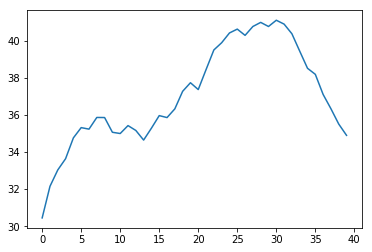

In [13]:
plt.plot((test/test2)*100)

In [14]:
s1=-12
s2=9
ar = xr.open_dataarray(cnst.GRIDSAT + 'aggs/WAbox_meanT-50_hov_5000km2.nc')
mean = ar.mean('year').sel(lat=slice(4.5,14.5))
ar70 = xr.open_dataset(cnst.GRIDSAT + 'aggs/gridsat_WA_-70_monthly_mean_5000km2.nc')
ar50 = xr.open_dataset(cnst.GRIDSAT + 'aggs/gridsat_WA_-50_monthly_count.nc')
ar70c = xr.open_dataset(cnst.GRIDSAT + 'aggs/gridsat_WA_-70_monthly_count_5000km2.nc')
ar40 = xr.open_dataset(cnst.GRIDSAT + 'aggs/gridsat_WA_-40_monthly_count_-40base_1000km2.nc')
ar70 = ar70['tir'].sel(lon=slice(s1,s2), lat=slice(4.5,14.5)).groupby('time.month').mean('time').mean('lon')
ar70c = ar70c['tir'].sel(lon=slice(s1,s2), lat=slice(4.5,14.5)).groupby('time.month').mean('time').mean('lon')
ar50 = (ar50['tir'].sel(lon=slice(s1,s2), lat=slice(4.5,14.5))).groupby('time.month').mean('time').mean('lon')
ar40 = (ar40['tir'].sel(lon=slice(s1,s2), lat=slice(4.5,14.5))).groupby('time.month').mean('time').mean('lon')

In [15]:
ar50diff = ar50-ar70c

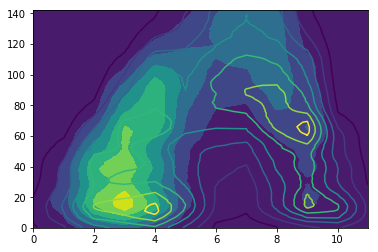

In [16]:
plt.contourf(ar70c.T)
plt.contour(ar50diff.T)

In [17]:
OBS2 = pkl.load( open (cnst.CLOVER_SAVES + 'bulk_-50_5000km2_GPM_ERA-I.p', 'rb'))
OBS1 = pkl.load( open (cnst.CLOVER_SAVES + 'bulk_-70_5000km2_GPM_ERA-I.p', 'rb'))
def create_dic(dic):
    pp = np.array(dic['pmax'])
    sh = np.array(dic['shear']) #np.array(dic['shear']) * (-1)
    umin = np.array(dic['u650'])
    umax = np.array(dic['u925'])
    qq = np.array(dic['q925']) 
    tt = np.array(dic['tmin'])
    ttm = np.array(dic['tmean'])
    month = np.array(dic['month'])
    area = np.array(dic['area'])
    lat = np.array(dic['clat'])
    lon = np.array(dic['clon'])

    obs_pcp = {
        'prcp' : pp,
        'u650' : umin,
        'u925' : umax,
        'q925' : qq*1000,
        'shear' : sh*-1,
        'month' : month,
        'area' : (area)*(5**2),
        'tmin' : tt,
        'tmean' : ttm,
        'lat' : lat,
        'lon' : lon,
    } 
    obs = pd.DataFrame(obs_pcp)
    return obs
obs_gpm = create_dic(OBS2)
obs_gpm70 = create_dic(OBS1)

In [18]:
OBS1.keys()

dict_keys(['area', 'shear', 'q925', 'pgt01isvalid', 'tmean', 'rh925', 'pgt30', 'rh650', 'pmax', 'pv925', 't', 'q650', 'month', 'v650', 'v925', 'hour', 'p', 'tmin', 'div925', 'lat', 't925', 'lon', 'u925', 'div650', 'w925', 'pmean', 'clat', 'u650', 'pv650', 'w650', 'year', 'clon', 't650'])

In [19]:
obs_gpm = obs_gpm[(obs_gpm.lon>=-10)&(obs_gpm.lon<=10)]
obs_gpm70 = obs_gpm70[(obs_gpm70.lon>=-10)&(obs_gpm70.lon<=10)]

In [20]:
lats = np.arange(4.5,9.1,0.5)
dic = {3 : [], 4:[], 5:[], 6:[], 7:[], 8:[], 9:[], 10:[], 11:[]}
dic_mean = {3 : [], 4:[], 5:[], 6:[], 7:[], 8:[], 9:[], 10:[], 11:[]}
dic_abs = {3 : [], 4:[], 5:[], 6:[], 7:[], 8:[], 9:[], 10:[], 11:[]}
dic_70 = {3 : [], 4:[], 5:[], 6:[], 7:[], 8:[], 9:[], 10:[], 11:[]}
gpmlist = []
for k in dic.keys():
    for ids, ll in enumerate(lats[0:-2]):
        #print('between', ll, lats[ids+1])
        storms = obs_gpm[(obs_gpm.lat>=ll)&(obs_gpm.lon<=lats[ids+1])&(obs_gpm.month==k)]
        storms70 = obs_gpm70[(obs_gpm70.lat>=ll)&(obs_gpm70.lon<=lats[ids+1])&(obs_gpm70.month==k)]
        summi = np.sum((storms['prcp']>50))/np.sum((storms['prcp']>0))
        summi70 = np.sum((storms70['prcp']>50))/np.sum((storms['prcp']>50))
        dic[k].append(summi)
        dic_mean[k].append(np.sum((storms['prcp']>0)))
        dic_abs[k].append(np.sum((storms['prcp']>50)))
        dic_70[k].append(summi70)
latbin = lats[1:-1]-0.25

/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in long_scalars
  del sys.path[0]


In [21]:
len(dic[6])

8

In [22]:
np.repeat(vdic['ERA_srfc']['t2m'].values, repeats = len(vdic['ERA_pl'].level), axis=0).reshape((len(vdic['ERA_pl'].level), len(vdic['ERA_srfc']['t2m'].values)))

NameError: name 'vdic' is not defined

In [25]:
## a clean way of plotting - use matplotlib functions directly:

def draw_cross(ax, data, lon, lat, title=None, xlabel=None, ylabel=None,  cmap=None,mask_sig=None, quiver=None, contour=None, cbar_label=None, twinx=None, cbar=True,**kwargs):

    mapp = ax.contourf(lon, lat, data, extend='both', alpha=0.8, cmap=cmap, **kwargs)  # this is the actual plot
    
#     cmapp = uplot.discrete_cmap(25, base_cmap=cmap)
#     mapp = ax.pcolormesh(lon, lat,data,cmap=cmapp, vmin=50, vmax=68)
    
    plt.gca().invert_yaxis()
    if mask_sig is not None:
         plt.contourf(lon, lat, mask_sig, colors='none', hatches='.',
                     levels=[0.5, 1], linewidth=0.1)
    
    if quiver is not None:
        qu = ax.quiver(quiver['x'], quiver['y'], quiver['u'], quiver['v'], scale=quiver['scale'], width=0.002, headwidth=7)
        
    if contour is not None:
        cs = ax.contour(contour['x'], contour['y'], contour['data'], levels=contour['levels'], colors=contour['colours'], linewidths=1.7, linestyles='solid' )
        plt.clabel(cs, inline=1, fontsize=12, fmt='%1.0f')
        
    if twinx is not None:
        ax1 = ax.twinx()
        ax1.plot(twinx['x'], twinx['y'], twinx['color'] )
        ax1.set_ylabel(twinx['ylabel'])
        ax1.set_ylim(twinx['ylim'][0], twinx['ylim'][1])
    
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    if cbar:
        cbar = plt.colorbar(mapp, pad=0.09, format='%d')  # adds colorbar
        #cbar = plt.colorbar(mapp, ticks=np.linspace(50,68,25), pad=0.09)
        cbar.set_label(cbar_label)
    
    #return mapp


In [26]:
era_pl['ymonth'] = ('time', [str(m)+'-'+str(h) for (m,h) in zip(era_pl['time.month'].values,era_pl['time.hour'].values)])
grouped='ymonth'
era_pl_cross =  era_pl.groupby(grouped).mean(dim='time')

In [27]:
era_srfc['ymonth'] = ('time', [str(m)+'-'+str(h) for (m,h) in zip(era_srfc['time.month'].values,era_srfc['time.hour'].values)])
grouped='ymonth'
era_srfc_cross =  era_srfc.groupby(grouped).mean(dim='time')

/home/ck/miniconda3/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [28]:
def sel_month(m1):

    cross_march = era_pl_cross.sel(ymonth=str(m1)+'-12', longitude=slice(-10,10), latitude=slice(3.5,15)).mean('longitude')
    cross_marchs = era_srfc_cross.sel(ymonth=str(m1)+'-12', longitude=slice(-10,10), latitude=slice(3.5,15)).mean('longitude')
    cross_m_shear = cross_march.sel(level=650)-cross_march.sel(level=900)
    
    cross_mse = u_met.moist_static_energy(cross_march['t'].values-273.15, cross_march['q'].values, geop=cross_march['z'].values)
    cross_dse = u_met.dry_static_energy(cross_march['t'].values-273.15, geop=cross_march['z'].values)
    cross_theta = u_met.theta(era_pl_cross.level.values, cross_march['t'].values-273.15)
    cross_theta_e = u_met.theta_e(era_pl_cross.level.values, cross_march['t'].values-273.15, cross_march['q'].values)
    
    
    pdub = np.array([list(era_pl_cross.level.values),]*17).T
    p = units.Quantity(pdub, 'hPa')
    
    
    t = units.Quantity(cross_march['t'].values, 'K')
    
    cross_theta_es = calc.saturation_equivalent_potential_temperature(p,t)
    
    cross_prcp_march = chov.sel(month=m1)
    cross_meanT_march = mean.sel(month=m1)
    cross_70_march = ar70c.sel(month=m1)
    cross_50_march = ar50.sel(month=m1)
    cross_40_march = ar40.sel(month=m1)
    cross_50_no70 = ar50diff.sel(month=m1)
    ext_frac_m = dic[m1]
    ext_mean_m = dic_mean[m1]
    ext_abs_m = dic_abs[m1]
    ext_70_m = dic_70[m1]
    
    return {
       'ERA_pl' : cross_march,
        'ERA_srfc' : cross_marchs,
        'ERA_shear' : cross_m_shear,
        'CHIRPS' : cross_prcp_march,
        'meanT_-50' : cross_meanT_march,
        'cover70' : cross_70_march,
        'cover50' : cross_50_march,       
        'cover40' : cross_40_march,  
        'cover50no70' : cross_50_no70, 
        'extremeFrac70' : ext_frac_m,
        'noZero70' : ext_mean_m,
        'extremeAbs70' : ext_abs_m,
        'extreme70Frac50' : ext_70_m,
        'mse' : cross_mse,
        'dse' : cross_dse,
        'theta' : cross_theta,
        'theta_e' : cross_theta_e,
        'theta_es' : np.array(cross_theta_es)
    }

In [29]:
vdic['ERA_pl'].latitude[:8]

NameError: name 'vdic' is not defined

In [30]:
vdic = sel_month(3)

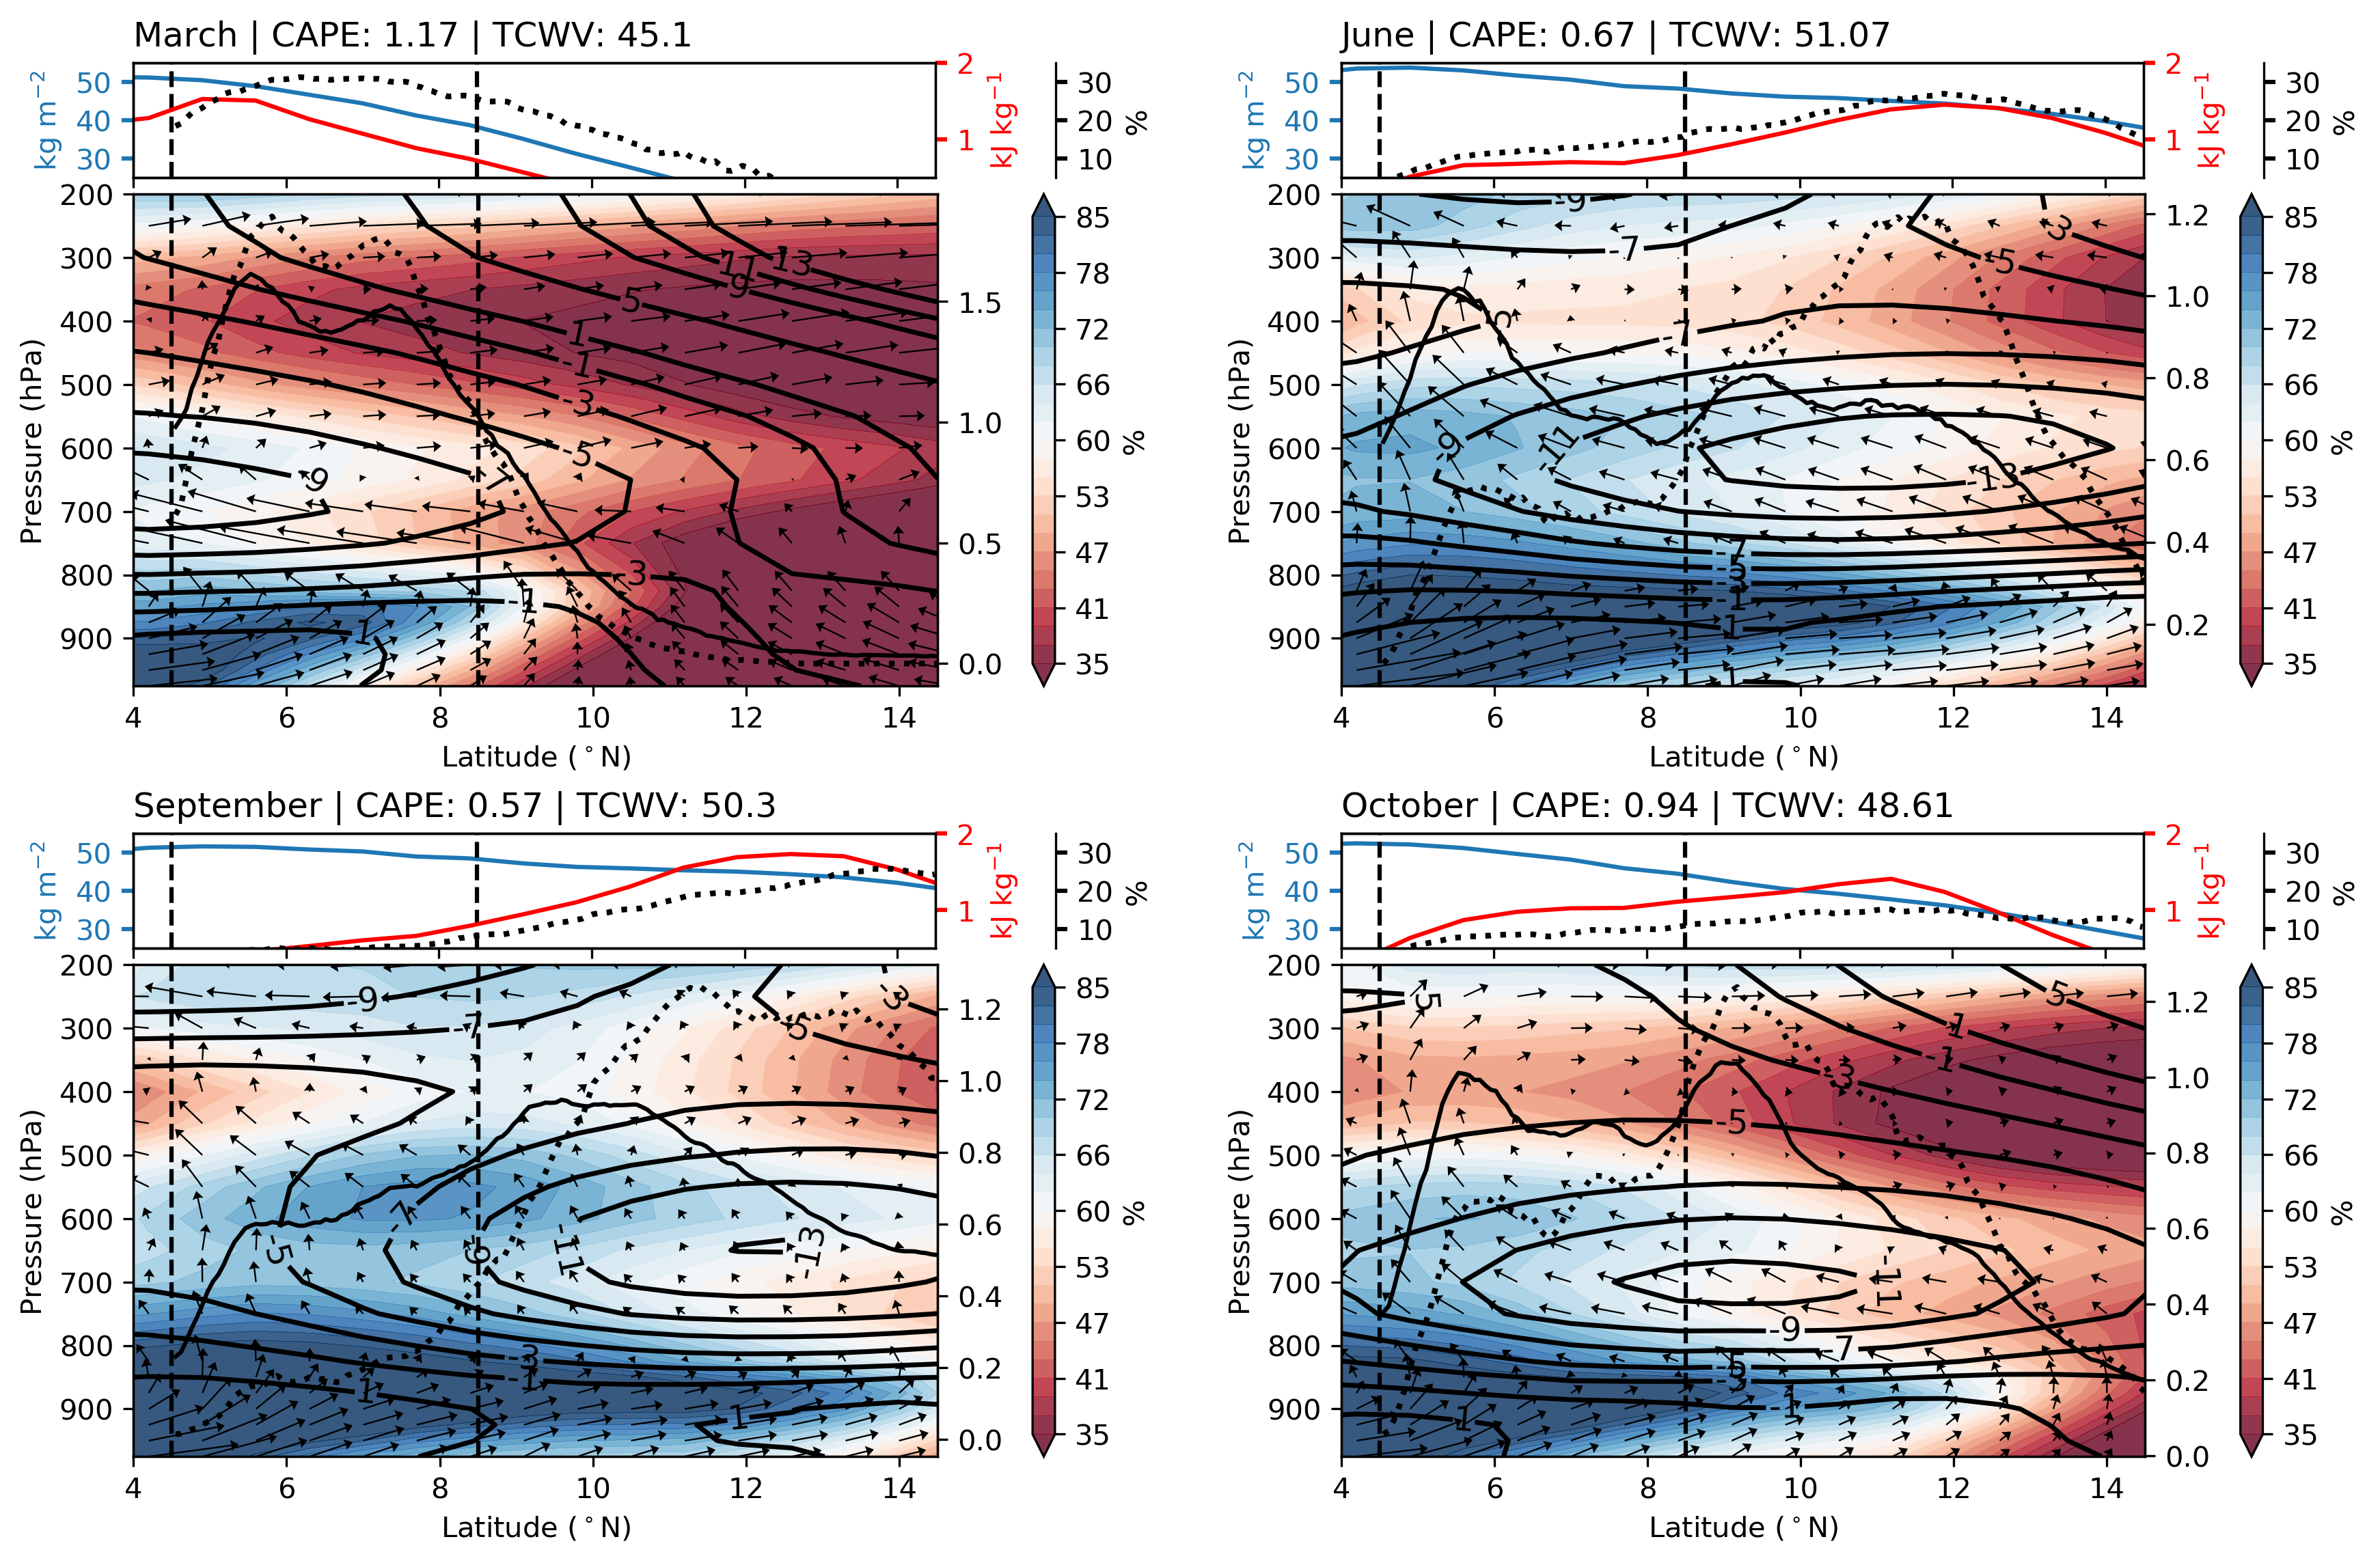

In [42]:

f=plt.figure(figsize=(12,8), dpi=300)  # this opens a plot window

vdic['ERA_pl'] = vdic['ERA_pl'].sel(level=slice(975,300))

left, width, width2 = 0.061, 0.43, 0.326#0.345
space=0.01
left2 = left + width + left

bottom, height, height2 = 0.07, 0.3, 0.07
bottom1 = bottom + height + space


bottom2 = bottom+height + height2 + space*10
bottom22 = bottom2  + height + space

cross1 = [left, bottom, width, height]
cross2 = [left+width+left, bottom, width, height]
line1 = [left, bottom1, width2, height2]
line2 = [left+width+left, bottom1, width2, height2]

cross3 = [left, bottom2, width, height]
cross4 = [left+width+left, bottom2, width, height]
line3 = [left, bottom22, width2, height2]
line4 = [left+width+left, bottom22, width2, height2]

pdic = {3 : (cross3,line3,'March'), 6 : (cross4, line4,'June'), 9 : (cross1, line1,'September'), 10 : (cross2, line2,'October') }

for k in pdic.keys():#ids, m in enumerate(np.array([3,6,9,10])):
    
    m = k
    p1 = pdic[k][0]
    p2 = pdic[k][1]
    mname = pdic[k][2]
    

    ylabel = 'Pressure (hPa)'
    cbar=True
    xlabel = r'Latitude ($^\circ$N)'
    
    vdic = sel_month(m)

#     ax = plt.axes(p1)#f.add_subplot(2,2,ids+1)
#     t2 = np.repeat(vdic['ERA_srfc']['t2m'].values, repeats = len(vdic['ERA_pl'].level), axis=0).reshape((len(vdic['ERA_srfc']['t2m'].values), len(vdic['ERA_pl'].level))).T
#     cs = ax.contour(vdic['ERA_srfc'].latitude,vdic['ERA_pl'].level, t2-273.15, levels=np.arange(25,36,1))
#     plt.clabel(cs, inline=1, fontsize=10)
    
    # "current zonal wind" wind vectors
    vano = vdic['ERA_pl']['v']
    wano = vdic['ERA_pl']['w']*(-10)  # multiplied by 10 since vertical component is very small compared to horizontal one
    st=1
    sarrow = 1
    xquiv = vdic['ERA_pl'].latitude[sarrow::st]
    yquiv = vdic['ERA_pl'].level

    uu = (vano)[::, sarrow::st]  
    ww = (wano)[::, sarrow::st]

    qin = {'x' : xquiv, 'y' : yquiv, 'u' : uu, 'v' : ww, 'scale' : 30}

    # temperature and moisture check
    data = (vdic['ERA_pl']['u'])
    data2 = vdic['ERA_pl']['r'] #np.linspace(50,68,25)
    #data2 = (vdic['ERA_pl']['r'])
    ax = plt.axes(p1)
    contour = {'data' : data, 'x' : vdic['ERA_pl'].latitude, 'y' : vdic['ERA_pl'].level, 'levels' : [-13,-11,-9,-7,-5,-3,-1,1,5,9,11,13], 'colours' : 'k'}
    draw_cross(ax, data2, vdic['ERA_pl'].latitude, vdic['ERA_pl'].level, cmap='RdBu', 
               levels=np.linspace(35,85,25), quiver=qin, contour=contour, cbar_label='%', cbar=cbar, xlabel=xlabel, ylabel=ylabel)
    ax.set_xlim(4,14.5)
    ax2 = ax.twinx()
    ax2.plot(vdic['cover40'].lat,(vdic['cover40'].values/np.sum(vdic['cover40'].values))*100, 'k-')
    ax2.plot(vdic['cover70'].lat,(vdic['cover70'].values/np.sum(vdic['cover70'].values))*100, color='k',  linestyle='dotted', linewidth=2)
    
    plt.axvline(x=4.5, color='k', linestyle='dashed')
    plt.axvline(x=8.5, color='k', linestyle='dashed')

    ##############################################
    ax1 = plt.axes(p2)
    ax1.set_xticklabels([])

    pl1, = ax1.plot(vdic['ERA_pl'].latitude,vdic['ERA_srfc']['tcwv'])
    plt.axvline(x=4.5, color='k', linestyle='dashed')
    plt.axvline(x=8.5, color='k', linestyle='dashed')
    #thetae = vdic['theta_e'][15:18,:].mean(axis=0)-(vdic['theta_es'][8:11,:].mean(axis=0)-273.15)
    #thetae = vdic['theta_e'][15:18,:].mean(axis=0)-(vdic['theta_e'][8:11,:].mean(axis=0))
    #thetae = vdic['theta_e'][18,:]-(vdic['theta_es'][8,:]-273.15)
    thetae = vdic['ERA_srfc']['cape'].values/1000
    #ipdb.set_trace()
    ax1.set_title(mname + r' | CAPE: ' + str(np.round(np.mean(thetae[2:8]),2)) + ' | TCWV: ' + str(np.round(np.mean(vdic['ERA_srfc']['tcwv'].values[2:8]),2))
                  , loc='left', fontsize=12)
    
    ax1.set_ylim(25,55)
    ax1.set_xlim(4,14.5)
    ax5 = ax1.twinx()

    
    pl5, = ax5.plot(vdic['ERA_pl'].latitude, thetae , '-r')
    #ax5.set_ylim(5,16)
    ax5.set_ylim(0.5,2)
    

    ax6 = ax1.twinx()
    
    pl6, = ax6.plot(vdic['cover50'].lat,vdic['cover70'].values/vdic['cover50'].values*100, color='k', linestyle='dotted', linewidth=2)
    ax6.set_ylim(5,35)
    
    
    ax1.yaxis.label.set_color(pl1.get_color())
    ax5.yaxis.label.set_color(pl5.get_color())
    ax6.yaxis.label.set_color(pl6.get_color())
    
    tkw = dict(size=4, width=1.5)
    ax1.tick_params(axis='y', colors=pl1.get_color(), **tkw)
    ax5.tick_params(axis='y', colors=pl5.get_color(), **tkw)
    ax6.tick_params(axis='y', colors=pl6.get_color(), **tkw)
    
 
    ax6.spines["right"].set_position(("axes", 1.15))
    ax6.set_ylabel('%')
    ax5.set_ylabel(r'kJ kg$^{-1}$')
    ax1.set_ylabel(r'kg m$^{-2}$')
    
#plt.tight_layout()
#plt.savefig('/home/ck/DIR/cornkle/figs/CLOVER/paper1/crossS.jpg')

In [48]:
(vdic['cover70'].values/vdic['cover50'].values)*100


array([ 3.9989696,  4.3215895,  4.8542023,  5.451869 ,  5.9826093,
        6.4196835,  7.1693788,  7.3720226,  7.6169143,  8.201539 ,
        8.679358 ,  9.140421 ,  9.679003 , 10.106606 , 10.5037155,
       10.673358 , 10.748126 , 10.976921 , 11.138917 , 11.240338 ,
       11.3884   , 11.510582 , 11.554125 , 11.742338 , 11.916674 ,
       11.812048 , 12.392589 , 12.24031  , 12.3060055, 12.413851 ,
       11.884008 , 11.800301 , 12.397881 , 12.6867695, 12.946165 ,
       12.766257 , 12.71742  , 13.026079 , 12.966288 , 13.075648 ,
       13.2736635, 13.317479 , 13.537701 , 13.598974 , 13.585978 ,
       13.991399 , 14.178963 , 14.391481 , 14.590557 , 14.414765 ,
       14.32178  , 14.546697 , 14.568579 , 14.9746685, 15.303506 ,
       15.611872 , 15.664665 , 16.577135 , 16.862524 , 17.113281 ,
       17.57343  , 17.7528   , 17.645695 , 17.66128  , 17.809647 ,
       17.923605 , 18.010159 , 17.682425 , 17.780914 , 18.0636   ,
       18.21564  , 18.142904 , 18.784279 , 18.675764 , 19.2085

In [50]:
np.where(vdic['cover50'].lat <=8.5)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56]),)

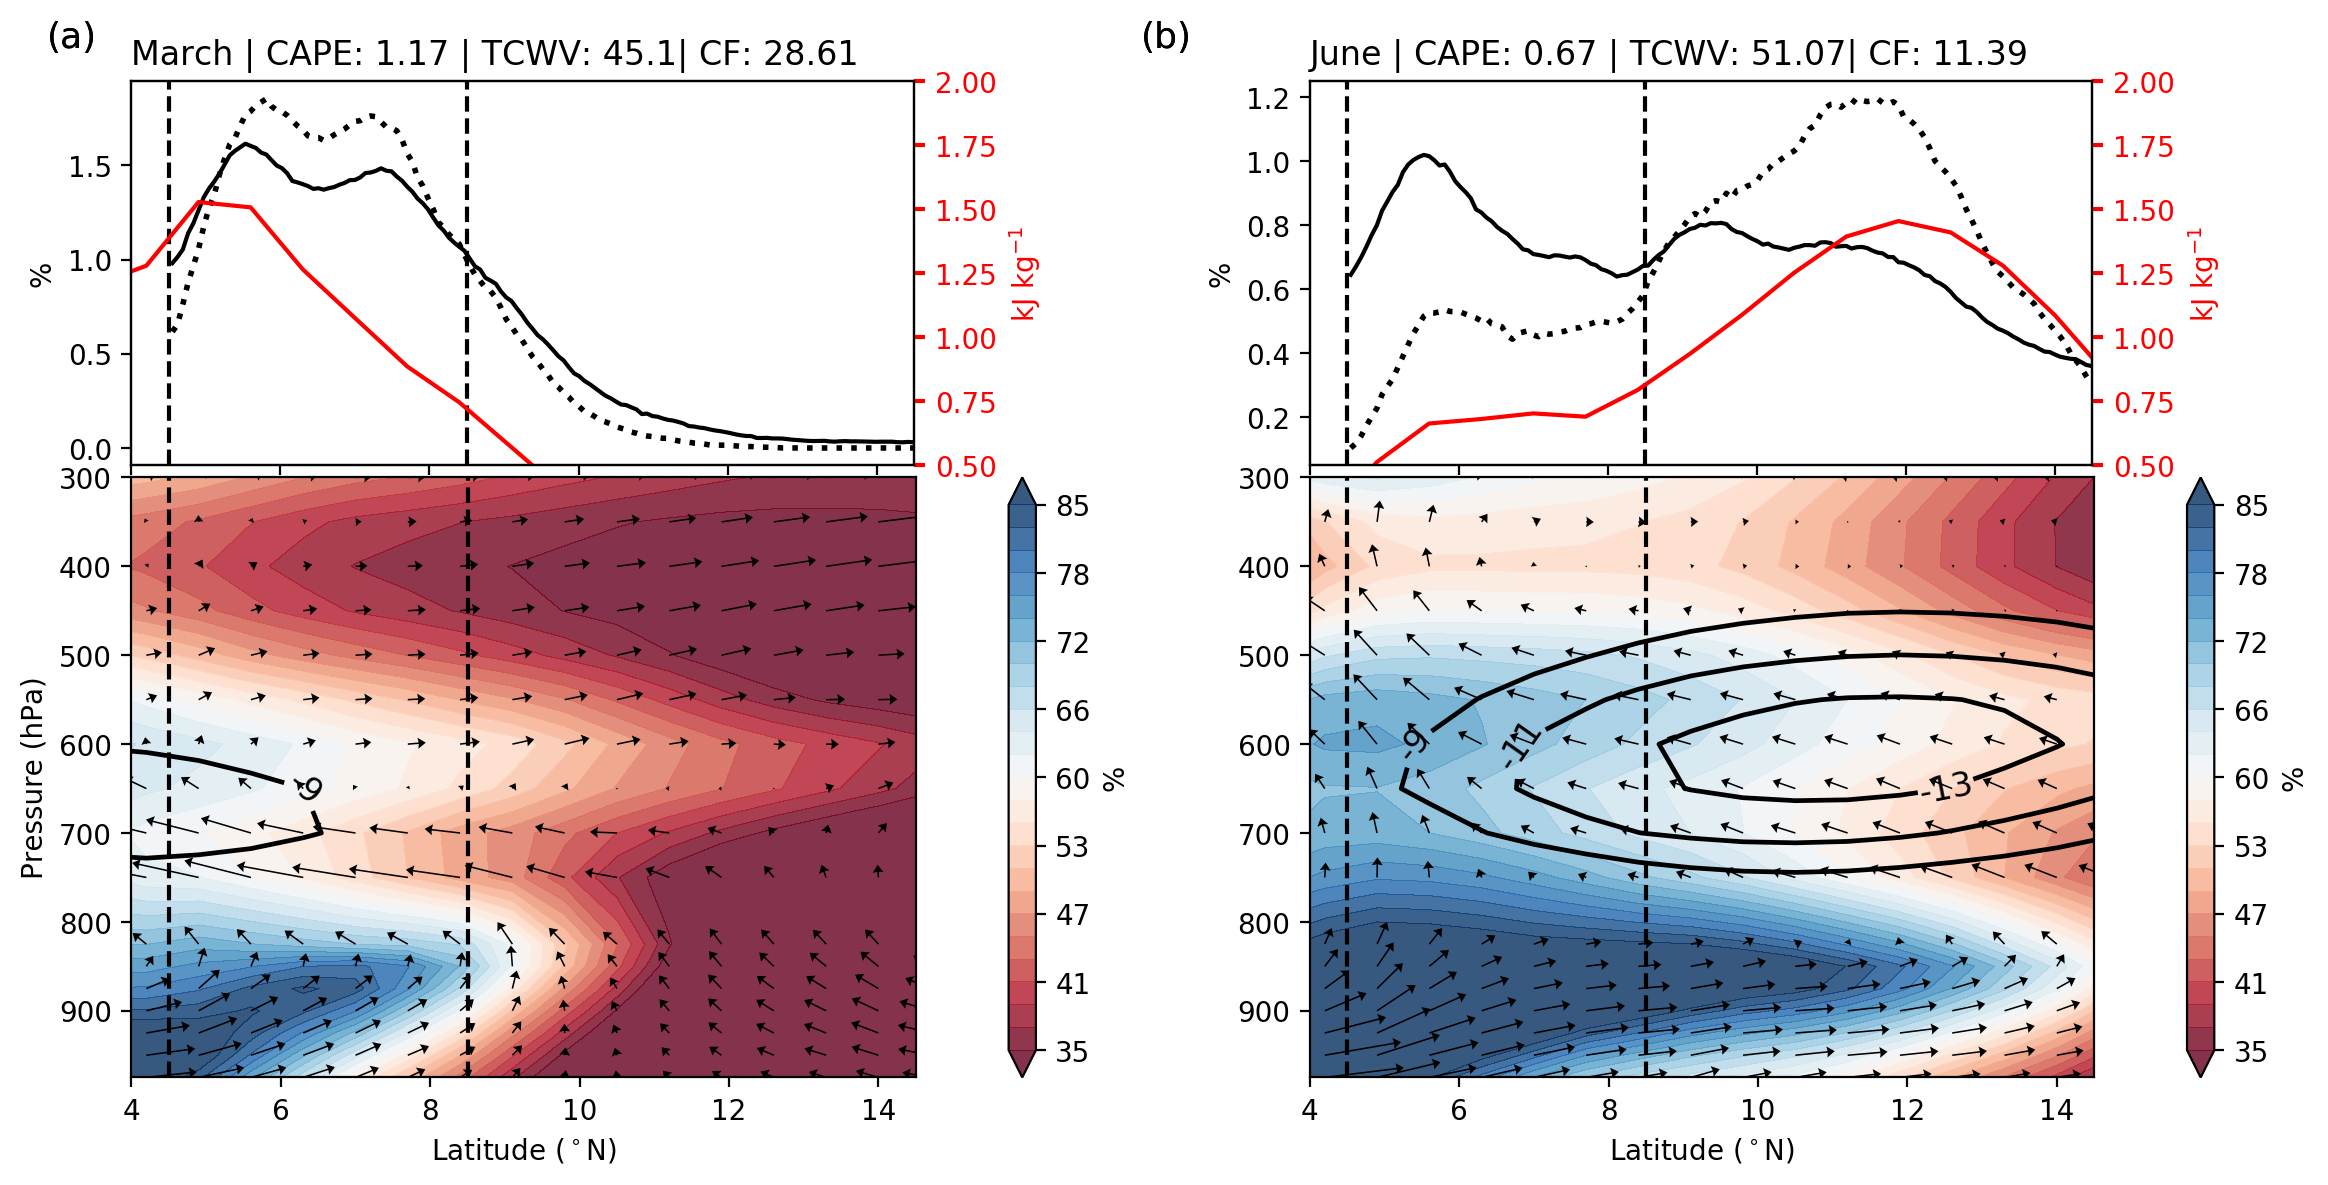

In [51]:

f=plt.figure(figsize=(12,6), dpi=200)  # this opens a plot window

left, width, width2 = 0.061, 0.43, 0.326#0.345
space=0.01
left2 = left + width + left

bottom, height, height2 = 0.1, 0.50, 0.32
bottom1 = bottom + height + space


bottom2 = bottom+height + height2 + space*10
bottom22 = bottom2  + height + space

cross1 = [left, bottom, width, height]
cross2 = [left+width+left, bottom, width, height]
line1 = [left, bottom1, width2, height2]
line2 = [left+width+left, bottom1, width2, height2]

cross3 = [left, bottom2, width, height]
cross4 = [left+width+left, bottom2, width, height]
line3 = [left, bottom22, width2, height2]
line4 = [left+width+left, bottom22, width2, height2]

pdic = {3 : (cross1,line1,'March'), 6 : (cross2, line2,'June')}

for ids, k in enumerate(pdic.keys()):#ids, m in enumerate(np.array([3,6,9,10])):
    
    m = k
    p1 = pdic[k][0]
    p2 = pdic[k][1]
    mname = pdic[k][2]
    
    if ids == 0:
        ylabel = 'Pressure (hPa)'
    else:
        ylabel = ''
        
        
    
    cbar=True
    xlabel = r'Latitude ($^\circ$N)'
    
    vdic = sel_month(m)
    vdic['ERA_pl'] = vdic['ERA_pl'].sel(level=slice(300,975))

#     ax = plt.axes(p1)#f.add_subplot(2,2,ids+1)
#     t2 = np.repeat(vdic['ERA_srfc']['t2m'].values, repeats = len(vdic['ERA_pl'].level), axis=0).reshape((len(vdic['ERA_srfc']['t2m'].values), len(vdic['ERA_pl'].level))).T
#     cs = ax.contour(vdic['ERA_srfc'].latitude,vdic['ERA_pl'].level, t2-273.15, levels=np.arange(25,36,1))
#     plt.clabel(cs, inline=1, fontsize=10)
    
    # "current zonal wind" wind vectors
    vano = vdic['ERA_pl']['v']
    wano = vdic['ERA_pl']['w']*(-10)  # multiplied by 10 since vertical component is very small compared to horizontal one
    st=1
    sarrow = 1
    xquiv = vdic['ERA_pl'].latitude[sarrow::st]
    yquiv = vdic['ERA_pl'].level

    uu = (vano)[::, sarrow::st]  
    ww = (wano)[::, sarrow::st]

    qin = {'x' : xquiv, 'y' : yquiv, 'u' : uu, 'v' : ww, 'scale' : 40}

    # temperature and moisture check
    data = (vdic['ERA_pl']['u'])
    data2 = vdic['ERA_pl']['r'] #np.linspace(50,68,25)
    #data2 = (vdic['ERA_pl']['r'])
    ax = plt.axes(p1)
    contour = {'data' : data, 'x' : vdic['ERA_pl'].latitude, 'y' : vdic['ERA_pl'].level, 'levels' : [-13,-11,-9], 'colours' : 'k'}
    draw_cross(ax, data2, vdic['ERA_pl'].latitude, vdic['ERA_pl'].level, cmap='RdBu', quiver=qin,
               levels=np.linspace(35,85,25), contour=contour, cbar_label='%', cbar=cbar, xlabel=xlabel, ylabel=ylabel)
    ax.set_xlim(4,14.5)
#     ax2 = ax.twinx()
#     ax2.plot(vdic['cover40'].lat,(vdic['cover40'].values/np.sum(vdic['cover40'].values))*100, 'k-')
#     ax2.plot(vdic['cover70'].lat,(vdic['cover70'].values/np.sum(vdic['cover70'].values))*100, color='k',  linestyle='dotted', linewidth=2)
    
    plt.axvline(x=4.5, color='k', linestyle='dashed')
    plt.axvline(x=8.5, color='k', linestyle='dashed')

    ##############################################
    ax1 = plt.axes(p2)
    ax1.set_xticklabels([])

    #pl1, = ax1.plot(vdic['ERA_pl'].latitude,vdic['ERA_srfc']['tcwv'])
      
    ax1.plot(vdic['cover40'].lat,(vdic['cover40'].values/np.sum(vdic['cover40'].values))*100, 'k-')
    ax1.plot(vdic['cover70'].lat,(vdic['cover70'].values/np.sum(vdic['cover70'].values))*100, color='k',  linestyle='dotted', linewidth=2)
    
    plt.axvline(x=4.5, color='k', linestyle='dashed')
    plt.axvline(x=8.5, color='k', linestyle='dashed')
    #thetae = vdic['theta_e'][15:18,:].mean(axis=0)-(vdic['theta_es'][8:11,:].mean(axis=0)-273.15)
    #thetae = vdic['theta_e'][15:18,:].mean(axis=0)-(vdic['theta_e'][8:11,:].mean(axis=0))
    #thetae = vdic['theta_e'][18,:]-(vdic['theta_es'][8,:]-273.15)
    thetae = vdic['ERA_srfc']['cape'].values/1000
    #ipdb.set_trace()
    
    coverfrac = np.sum(vdic['cover70'].values[0:56])/np.sum(vdic['cover50'].values[0:56])*100
    
    ax1.set_title(mname + r' | CAPE: ' + str(np.round(np.mean(thetae[2:8]),2)) + ' | TCWV: ' + str(np.round(np.mean(vdic['ERA_srfc']['tcwv'].values[2:8]),2)) + '| CF: '+ str(np.round(coverfrac,2))
                  , loc='left', fontsize=12)
    
    #ax1.set_ylim(25,55)
    ax1.set_xlim(4,14.5)
    #ax1.set_ylim(975,300)
    ax5 = ax1.twinx()

    
    pl5, = ax5.plot(vdic['ERA_pl'].latitude, thetae , '-r')
    #ax5.set_ylim(5,16)
    ax5.set_ylim(0.5,2)
    

    #ax6 = ax1.twinx()
    
    #pl6, = ax6.plot(vdic['cover50'].lat,vdic['cover70'].values/vdic['cover50'].values*100, color='k', linestyle='dotted', linewidth=2)
    #ax6.set_ylim(5,35)
    
    
    #ax1.yaxis.label.set_color(pl1.get_color())
    ax5.yaxis.label.set_color(pl5.get_color())
    #ax6.yaxis.label.set_color(pl6.get_color())
    
    tkw = dict(size=4, width=1.5)
    #ax1.tick_params(axis='y', colors=pl1.get_color(), **tkw)
    ax5.tick_params(axis='y', colors=pl5.get_color(), **tkw)
    #ax6.tick_params(axis='y', colors=pl6.get_color(), **tkw)
    
 
    #ax6.spines["right"].set_position(("axes", 1.15))
    ax1.set_ylabel('%')
    ax5.set_ylabel(r'kJ kg$^{-1}$')
    #ax1.set_ylabel(r'kg m$^{-2}$')
    
    plt.annotate('(a)', xy=(0.02, 0.95), xytext=(0, 4), size=13, xycoords=('figure fraction', 'figure fraction'),
                     textcoords='offset points')
    plt.annotate('(b)', xy=(0.49, 0.95), xytext=(0, 4), size=13, xycoords=('figure fraction', 'figure fraction'),
                     textcoords='offset points')
    
#plt.tight_layout()
plt.savefig('/home/ck/DIR/cornkle/figs/CLOVER/paper1/crossS_new.jpg')

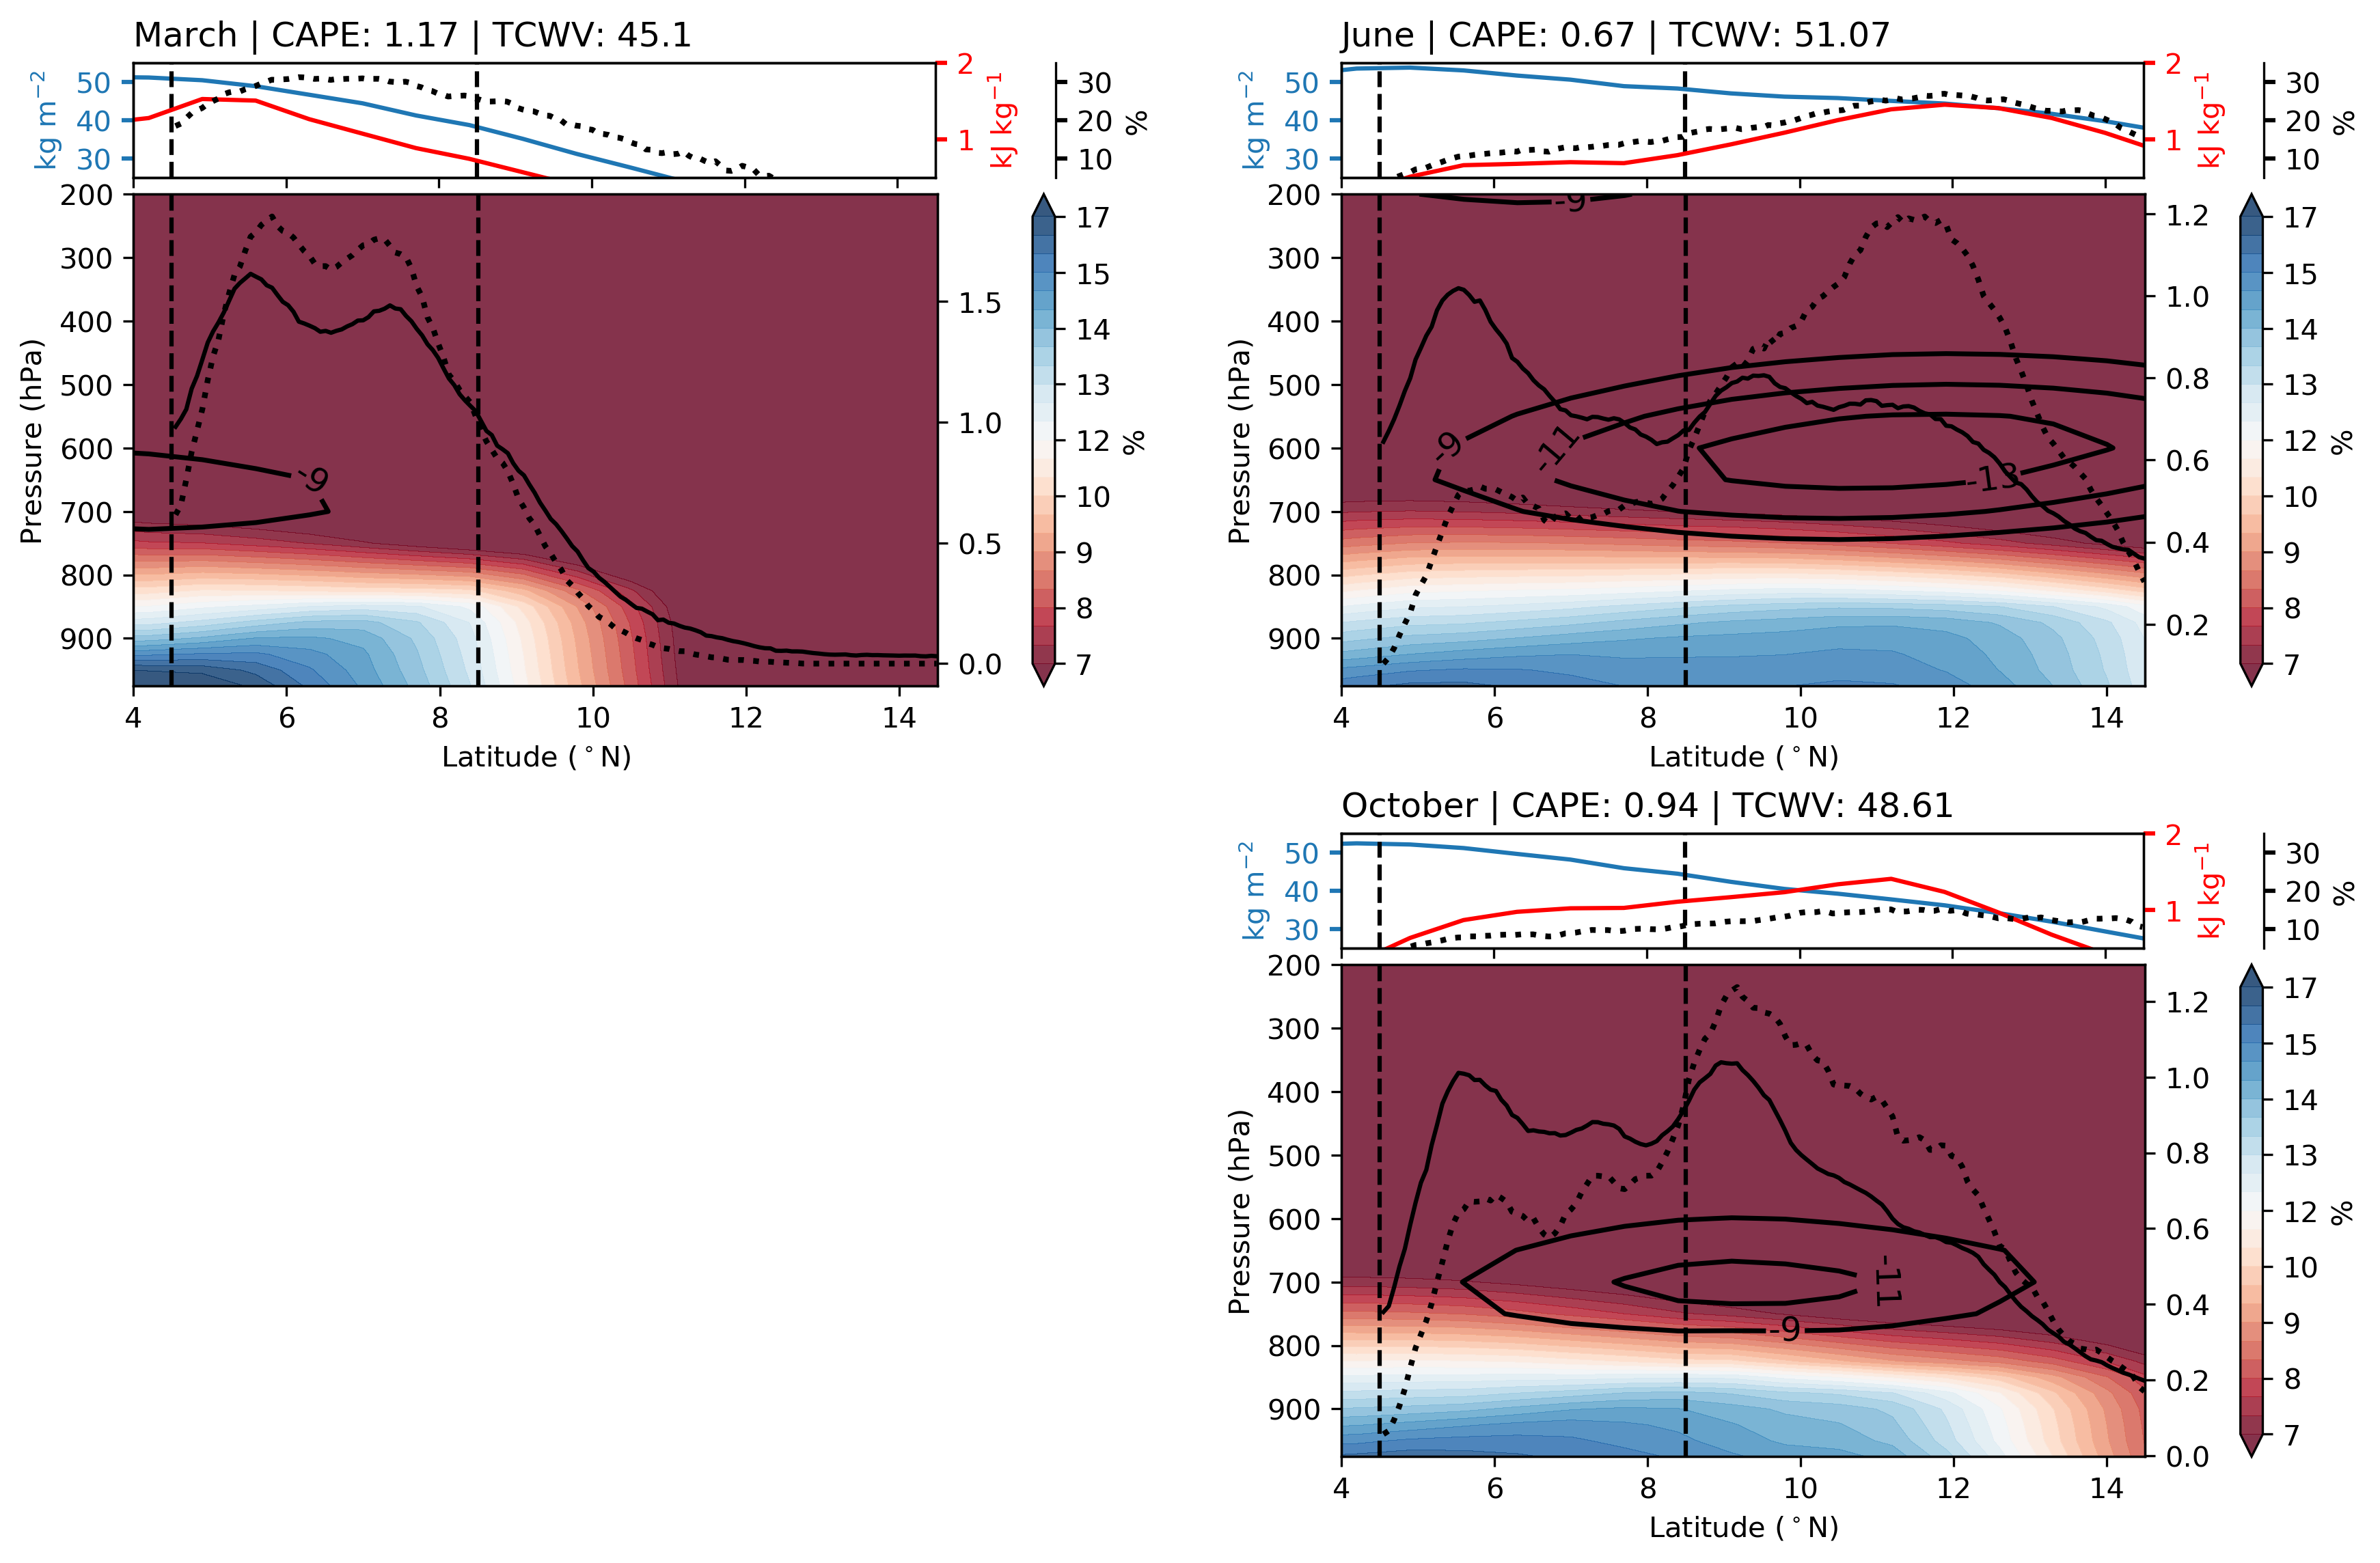

In [32]:

f=plt.figure(figsize=(12,8), dpi=300)  # this opens a plot window

left, width, width2 = 0.061, 0.43, 0.326#0.345
space=0.01
left2 = left + width + left

bottom, height, height2 = 0.07, 0.3, 0.07
bottom1 = bottom + height + space


bottom2 = bottom+height + height2 + space*10
bottom22 = bottom2  + height + space

cross1 = [left, bottom, width, height]
cross2 = [left+width+left, bottom, width, height]
line1 = [left, bottom1, width2, height2]
line2 = [left+width+left, bottom1, width2, height2]

cross3 = [left, bottom2, width, height]
cross4 = [left+width+left, bottom2, width, height]
line3 = [left, bottom22, width2, height2]
line4 = [left+width+left, bottom22, width2, height2]

pdic = {3 : (cross3,line3,'March'), 6 : (cross4, line4,'June'), 10 : (cross2, line2,'October') }

for k in pdic.keys():#ids, m in enumerate(np.array([3,6,9,10])):
    
    m = k
    p1 = pdic[k][0]
    p2 = pdic[k][1]
    mname = pdic[k][2]
    

    ylabel = 'Pressure (hPa)'
    cbar=True
    xlabel = r'Latitude ($^\circ$N)'
    
    vdic = sel_month(m)

#     ax = plt.axes(p1)#f.add_subplot(2,2,ids+1)
#     t2 = np.repeat(vdic['ERA_srfc']['t2m'].values, repeats = len(vdic['ERA_pl'].level), axis=0).reshape((len(vdic['ERA_srfc']['t2m'].values), len(vdic['ERA_pl'].level))).T
#     cs = ax.contour(vdic['ERA_srfc'].latitude,vdic['ERA_pl'].level, t2-273.15, levels=np.arange(25,36,1))
#     plt.clabel(cs, inline=1, fontsize=10)
    
    # "current zonal wind" wind vectors
    vano = vdic['ERA_pl']['v']
    wano = vdic['ERA_pl']['w']*(-10)  # multiplied by 10 since vertical component is very small compared to horizontal one
    st=1
    sarrow = 1
    xquiv = vdic['ERA_pl'].latitude[sarrow::st]
    yquiv = vdic['ERA_pl'].level

    uu = (vano)[::, sarrow::st]  
    ww = (wano)[::, sarrow::st]

    #qin = {'x' : xquiv, 'y' : yquiv, 'u' : uu, 'v' : ww, 'scale' : 30}

    # temperature and moisture check
    data = (vdic['ERA_pl']['u'])
    data2 = vdic['ERA_pl']['q']*1000 #np.linspace(50,68,25)
    #data2 = (vdic['ERA_pl']['r'])
    ax = plt.axes(p1)
    contour = {'data' : data, 'x' : vdic['ERA_pl'].latitude, 'y' : vdic['ERA_pl'].level, 'levels' : [-13,-11,-9], 'colours' : 'k'}
    draw_cross(ax, data2, vdic['ERA_pl'].latitude, vdic['ERA_pl'].level, cmap='RdBu', 
               levels=np.linspace(7,17,25), contour=contour, cbar_label='%', cbar=cbar, xlabel=xlabel, ylabel=ylabel)
    ax.set_xlim(4,14.5)
    ax2 = ax.twinx()
    ax2.plot(vdic['cover40'].lat,(vdic['cover40'].values/np.sum(vdic['cover40'].values))*100, 'k-')
    ax2.plot(vdic['cover70'].lat,(vdic['cover70'].values/np.sum(vdic['cover70'].values))*100, color='k',  linestyle='dotted', linewidth=2)
    
    plt.axvline(x=4.5, color='k', linestyle='dashed')
    plt.axvline(x=8.5, color='k', linestyle='dashed')

    ##############################################
    ax1 = plt.axes(p2)
    ax1.set_xticklabels([])

    pl1, = ax1.plot(vdic['ERA_pl'].latitude,vdic['ERA_srfc']['tcwv'])
    plt.axvline(x=4.5, color='k', linestyle='dashed')
    plt.axvline(x=8.5, color='k', linestyle='dashed')
    #thetae = vdic['theta_e'][15:18,:].mean(axis=0)-(vdic['theta_es'][8:11,:].mean(axis=0)-273.15)
    #thetae = vdic['theta_e'][15:18,:].mean(axis=0)-(vdic['theta_e'][8:11,:].mean(axis=0))
    #thetae = vdic['theta_e'][18,:]-(vdic['theta_es'][8,:]-273.15)
    thetae = vdic['ERA_srfc']['cape'].values/1000
    #ipdb.set_trace()
    ax1.set_title(mname + r' | CAPE: ' + str(np.round(np.mean(thetae[2:8]),2)) + ' | TCWV: ' + str(np.round(np.mean(vdic['ERA_srfc']['tcwv'].values[2:8]),2))
                  , loc='left', fontsize=12)
    
    ax1.set_ylim(25,55)
    ax1.set_xlim(4,14.5)
    ax5 = ax1.twinx()

    
    pl5, = ax5.plot(vdic['ERA_pl'].latitude, thetae , '-r')
    #ax5.set_ylim(5,16)
    ax5.set_ylim(0.5,2)
    

    ax6 = ax1.twinx()
    
    pl6, = ax6.plot(vdic['cover50'].lat,vdic['cover70'].values/vdic['cover50'].values*100, color='k', linestyle='dotted', linewidth=2)
    ax6.set_ylim(5,35)
    
    
    ax1.yaxis.label.set_color(pl1.get_color())
    ax5.yaxis.label.set_color(pl5.get_color())
    ax6.yaxis.label.set_color(pl6.get_color())
    
    tkw = dict(size=4, width=1.5)
    ax1.tick_params(axis='y', colors=pl1.get_color(), **tkw)
    ax5.tick_params(axis='y', colors=pl5.get_color(), **tkw)
    ax6.tick_params(axis='y', colors=pl6.get_color(), **tkw)
    
 
    ax6.spines["right"].set_position(("axes", 1.15))
    ax6.set_ylabel('%')
    ax5.set_ylabel(r'kJ kg$^{-1}$')
    ax1.set_ylabel(r'kg m$^{-2}$')
    
#plt.tight_layout()
#plt.savefig('/home/ck/DIR/cornkle/figs/CLOVER/paper1/crossS.jpg')